Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 128, 64, 1)
conv1 		 (?, 128, 64, 4)
pool1 		 (?, 64, 32, 4)
conv2 		 (?, 64, 32, 8)
pool2 		 (?, 32, 16, 8)
Flatten 	 (?, 4096)
Dense 1		 (?, 4096)
Reshape 	 (?, 32, 16, 8)
upsampl1 	 (?, 64, 32, 8)
deconv1 	 (?, ?, ?, 4)
upsampl2 	 (?, 128, 64, 4)
deconv		 (?, ?, ?, 1)
Model consits of  16782769 trainable parameters.
0.714205
Forward pass successful!
Begin training loop
Epoch 1 : Train Loss 3670.427, Valid loss 4359.168
Epoch 2 : Train Loss 2360.976, Valid loss 3687.528
Epoch 3 : Train Loss 2160.028, Valid loss 3524.511
Epoch 4 : Train Loss 1854.122, Valid loss 3599.986
Epoch 5 : Train Loss 1553.103, Valid loss 3731.698
Epoch 6 : Train Loss 1381.708, Valid loss 3814.124
Epoch 7 : Train Loss 1306.185, Valid loss 3832.813
Epoch 8 : Train Loss 1241.029, Valid loss 3802.083
Epoch 9 : Train Loss 1168.964, Valid loss 3740.788
Epoch 10 : Train Loss 1094.199, 

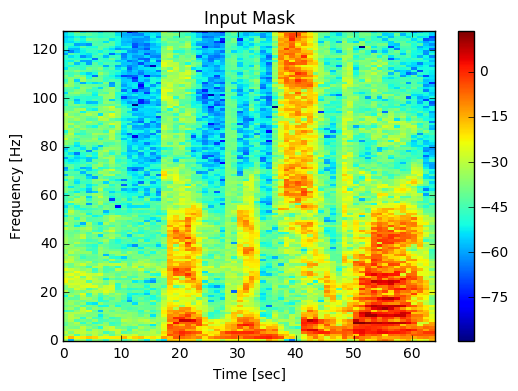

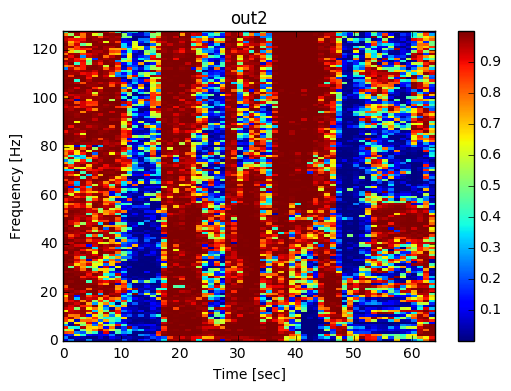

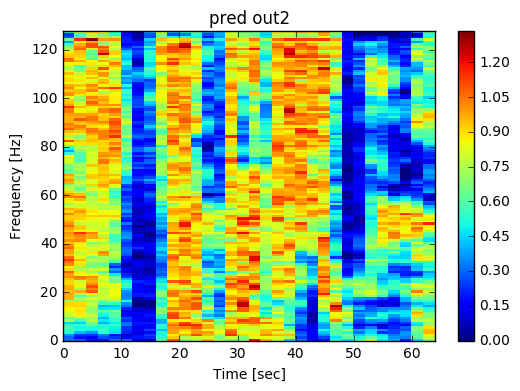

1.33741


(<matplotlib.text.Text at 0x7f4900901c50>,
 <matplotlib.text.Text at 0x7f4978a33e10>)

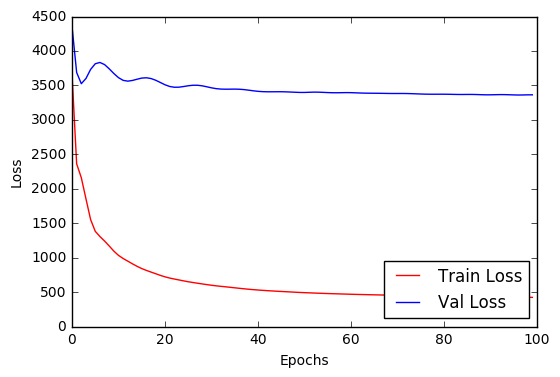

In [9]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
import utils
from librispeech_mixer import LibriSpeechMixer
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Reshape
from tensorflow.contrib.layers import flatten

tf.reset_default_graph()


#Create the LibriSpeech mixer
mixer = LibriSpeechMixer()
width = mixer.spec_length
validation_mixer = LibriSpeechMixer(False)

height, width, nchannels = mixer.nb_freq, mixer.spec_length, 1
padding = 'same'

filters_1 = 4
kernel_size_1 = (20,1)
kernel_size_2 = (1,20)
pool_size_1 = (2,2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, height, width, 1], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding='valid')
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    
    conv2 = Conv2D(2*filters_1, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())
    
    pool2 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding='valid')
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    
    reshape_size = x.get_shape()[1:]
    reshape_size = (int(reshape_size[0]), int(reshape_size[1]), int(reshape_size[2]))
     
    x = flatten(x)
    print('Flatten \t', x.get_shape())
    
    nb_units = int(x.get_shape()[1])
    
    dense1 = Dense(nb_units, activation='relu')
    x = dense1(x)
    print("Dense 1\t\t", x.get_shape())
    
    """dense2 = Dense(nb_units, activation='relu')
    x = dense2(x)
    print("Dense 2\t", x.get_shape())"""
    
    reshape = Reshape(reshape_size)
    x = reshape(x)
    print("Reshape \t", x.get_shape())
    
    upsampl1 = UpSampling2D(size=pool_size_1)
    x = upsampl1(x)
    print('upsampl1 \t', x.get_shape())
    
    deconv1 = Conv2DTranspose(filters_1, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = deconv1(x)
    print('deconv1 \t', x.get_shape())
    
    upsampl2 = UpSampling2D(size=pool_size_1)
    x = upsampl2(x)
    print('upsampl2 \t', x.get_shape())
    

with tf.variable_scope('output_layer'):
    deconv2 = Conv2DTranspose(1, kernel_size_1, strides=(1,1), padding=padding, activation='sigmoid')

    y = deconv2(x)
    print('deconv\t\t', y.get_shape())

print('Model consits of ', utils.num_params(), 'trainable parameters.')

gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

"""## Launch TensorBoard, and visualize the TF graph

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)"""


with tf.variable_scope('loss'):
    # computing cross entropy per sample
    mean_square_error = tf.reduce_sum((y_pl - y)**2)



with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(mean_square_error)

#Test the forward pass
batch_size = 1

x_batch, y_batch = mixer.get_batch(batch_size)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})
    print(np.max(y_pred))

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!"         + " Output shape should be " + str(y_batch.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')


# ## Training

#Training Loop

max_epochs = 100


valid_loss = []
train_loss = []
test_loss = []
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)

def trainingLoog():
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
        sess.run(tf.global_variables_initializer())
        print('Begin training loop')

        try:

            while mixer.epochs_completed < max_epochs:
                _train_loss = []

                ## Run train op
                x_batch, y_batch = mixer.get_batch(batch_size)
                fetches_train = [train_op, mean_square_error]
                feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
                _, _loss = sess.run(fetches_train, feed_dict_train)

                _train_loss.append(_loss)

                ## Compute validation loss
                if mixer.index_in_epoch < batch_size:
                    _valid_loss = []
                    train_loss.append(np.mean(_train_loss))

                    fetches_valid = [mean_square_error]

                    while validation_mixer.epochs_completed <= mixer.epochs_completed:
                        x_valid, y_valid = validation_mixer.get_batch(batch_size)
                        feed_dict_valid = {x_pl: x_valid, y_pl: y_valid}
                        _loss = sess.run(fetches_valid, feed_dict_valid)

                        _valid_loss.append(_loss)

                    valid_loss.append(np.mean(_valid_loss))


                    print("Epoch {} : Train Loss {:6.3f}, Valid loss {:6.3f}".format(
                        mixer.epochs_completed, train_loss[-1], valid_loss[-1]))                 
        
        except KeyboardInterrupt:
            pass
        
        x_batch, y_batch = mixer.get_batch(batch_size)
        y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})
        
        plt.pcolormesh(10 * np.log10(x_batch[0,:,:,0]+1e-10))
        plt.axis('tight')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title('Input Mask')
        plt.colorbar()
        plt.show()
        
                       
        plt.pcolormesh(y_batch[0,:,:,0])
        plt.axis('tight')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title('out2')
        plt.colorbar()
        plt.show()
        
        plt.pcolormesh(y_pred[0,:,:,0])
        plt.axis('tight')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title('pred out2')
        plt.colorbar()
        plt.show()
        
        print(np.max(y_pred))
    
trainingLoog();


    
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss,'r', epoch, valid_loss,'b')
plt.legend(['Train Loss','Val Loss'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Loss')